In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

from google.colab import drive, files

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/ai2_del2_face_recognition/Server/dataset/age-gender-recog-dataset.zip' -d '/content/'

Archive:  /content/drive/My Drive/Colab Notebooks/ai2_del2_face_recognition/Server/dataset/age-gender-recog-dataset.zip
replace /content/age-gender-recog-dataset/1_0_0_20161219140623097.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Load the Dataset

In [ ]:
# Preprocessing steps
BASE_DIR = '/content/age-gender-recog-dataset'

In [ ]:
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

100%|██████████| 23708/23708 [00:00<00:00, 535724.80it/s]


### Exploratory Data Analysis

In [ ]:
# Convert to DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels
})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Plot the age distribution
sns.displot(df['age'], kde=False)
plt.title("Age Distribution")
plt.show()

In [ ]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

# Use plain tuples to access rows
for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)

    file = row[0]
    age = row[1]

    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

plt.show()

### Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])
X = X / 255.0
y_age = np.array(df['age'])

100%|██████████| 23708/23708 [00:25<00:00, 920.39it/s] 


In [ ]:
X.shape

(23708, 128, 128, 1)

### Model Creation

In [ ]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

# Define the convolutional layers for age prediction
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
batchnorm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(batchnorm_1)
dropout_conv_1 = Dropout(0.3)(maxp_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(batchnorm_2)
dropout_conv_2 = Dropout(0.3)(maxp_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)
dropout_conv_3 = Dropout(0.3)(maxp_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
batchnorm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)
dropout_conv_4 = Dropout(0.3)(maxp_4)

flatten = Flatten()(dropout_conv_4)

# Fully connected layers with L2 regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)

dropout_1 = Dropout(0.5)(dense_1)

output_2 = Dense(1)(dropout_1)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_age_model.keras', monitor='val_loss', save_best_only=True)
]

In [ ]:
history = model.fit(
    x=X,
    y=y_age,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 371.7350 - mae: 14.4080 - val_loss: 323.1490 - val_mae: 14.2373 - learning_rate: 1.0000e-04
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 183.1353 - mae: 9.9880 - val_loss: 660.9709 - val_mae: 21.6151 - learning_rate: 1.0000e-04
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 159.3782 - mae: 9.2633 - val_loss: 1078.8987 - val_mae: 29.4022 - learning_rate: 1.0000e-04
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 148.9144 - mae: 8.9160 - val_loss: 1128.4952 - val_mae: 30.7345 - learning_rate: 1.0000e-04
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 137.9530 - mae: 8.5168 - val_loss: 150.1998 - val_mae: 9.1250 - learning_rate: 1.0000e-04
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 134.2143 - mae: 8.3966 - val_loss: 224.5516 - val_mae: 11.8736 - learning_rate: 1.0000e-04
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 128.1073 - 

In [ ]:
# Download the Best Age Model from Colab
files.download('best_age_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot the results

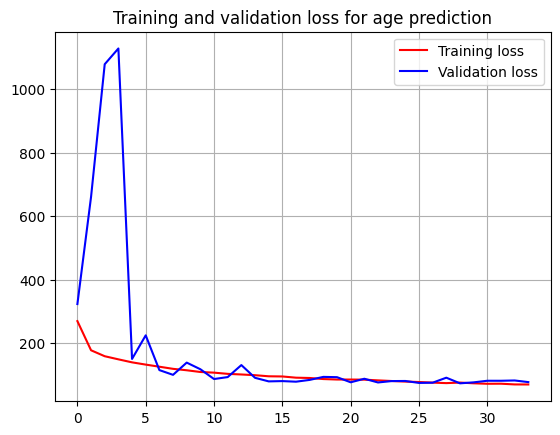

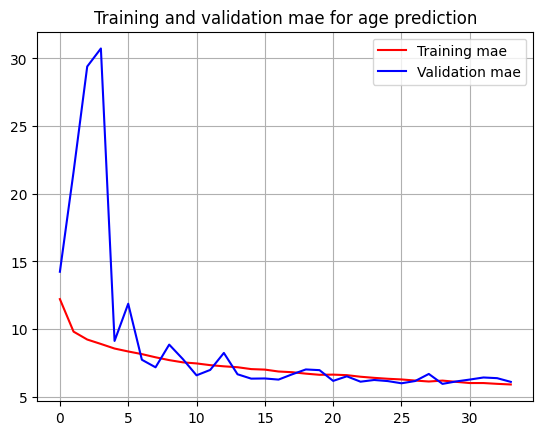

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot results for age
loss = history.history.get('loss', history.history.get('loss'))
val_loss = history.history.get('val_loss', history.history.get('val_loss'))

epochs = range(len(loss))

# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for age prediction')
plt.legend()
plt.grid()
plt.show()
plt.figure()

# plot results for age
mae = history.history.get('mae', history.history.get('mae'))
val_mae= history.history.get('val_mae', history.history.get('val_mae'))

epochs = range(len(mae))

# Plot training and validation mae
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae for age prediction')
plt.legend()
plt.grid()
plt.show()
plt.figure()

In [ ]:
# Access validation MAE from the training history
val_age_mae = history.history['val_mae'][-1]
print(f"Validation Mean Absolute Error for Age Prediction: {val_age_mae:.2f}")

Validation Mean Absolute Error for Age Prediction: 6.10


### Prediction with Test Data

Original Age:  30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
Predicted Age: 27-31


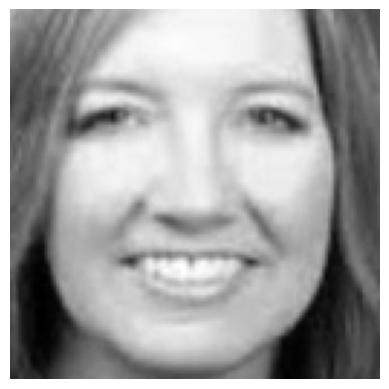

In [ ]:
# Age Prediction Code with Post-Processing
image_index = 28
print("Original Age: ", y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age_value = pred[0][0]

# Ensure age is not less than 1 and predict a range
pred_age_value = max(1, pred_age_value)
range_width = max(2, int(0.05 * pred_age_value))  # 5% of predicted age, with a minimum range of 2
pred_age_lower = max(1, round(pred_age_value - range_width))  # Lower bound
pred_age_upper = round(pred_age_value + range_width)  # Upper bound

print(f"Predicted Age: {pred_age_lower}-{pred_age_upper}")

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()